In [1]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import r2_score, accuracy_score, f1_score 
from hdbscan import HDBSCAN, approximate_predict
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
import os, pickle, sys, torch, tqdm
import numpy as np
sys.path.append('..')
from utils.spectrum import read_spectrum, denorm_spectrum, get_mask, norm_spectrum
import matplotlib.pyplot as plt
from torch.nn.functional import interpolate

In [9]:
x0, ys0 = read_spectrum(692)
x1, ys1 = read_spectrum(694)
x2, ys2 = read_spectrum('/mnt/MODELS/super_res/pl/s84_cvd_ws2/dbpn/basetune/s05_2x_all/00010.valid/692_2x_694.txt')

## read all data

In [2]:
roots = {
    'ws':'/home/jhyang/WORKSPACES/MODELS/super_res/pl/s84_cvd_ws2',
    'wse':'/home/jhyang/WORKSPACES/MODELS/super_res/pl/s76_cvd_wse2',
    'mose':'/home/jhyang/WORKSPACES/MODELS/super_res/pl/s63_exf_mose2',
}
N = 0
origs = {}
outputs = {}
for mat, root in roots.items():
    if mat not in outputs.keys():
        outputs[mat] = {'dbpn':{'b':{}, 'f':{}, 's':{}}, 'rbpn':{'b':{}, 'f':{}, 's':{}}}
    for m in ['dbpn','rbpn']:
        for t in ['basetune','finetune','scratch']:
            _t = t[0]
            path = os.path.join(root, m, t)
            if not os.path.isdir(path): continue
            for c in os.listdir(path):
                if '2x' not in c: continue
                if c.endswith('20') or c.endswith('40'): continue
                _c = c.split('_')[0]
                output = {}
                for i in range(1,20):
                    d = f'{i*10:05d}.valid'
                    path_dir = os.path.join(path, c, d)
                    if not os.path.isdir(path_dir):
                        continue
                    for fn in os.listdir(path_dir):
                        if '.bkup' in fn: continue
                        i1, i2 = fn.replace('_2x','').replace('.txt','').split('_')
                        k = f'{i1}_{i2}'
                        if k not in output.keys():
                            output[k] = {}
                        if i1 not in origs.keys():
                            origs[i1] = read_spectrum(i1, transpose_y=False)
                        if i2 != '' and i2 not in origs.keys():
                            origs[i2] = read_spectrum(i2, transpose_y=False)
                        try:
                            x, ys = read_spectrum(fn, path_dir, transpose_y=False)
                            xi, ysi = origs[i1]
                            xt, yst = origs[i2]
                            mask = get_mask(xi, x)
                            n = np.sum(mask)
                            vmin, vmax, nysi = norm_spectrum(ysi[..., mask], vmin=np.min(ys), vmax=np.max(ys), mode='minmax')
                            _, _, nyst = norm_spectrum(yst[..., mask], vmin=vmin, vmax=vmax, mode='minmax')
                            _, _, nys = norm_spectrum(ys, vmin=vmin, vmax=vmax, mode='minmax')
                            output[k][i*10] = x, nysi.reshape(-1,n), nyst.reshape(-1,n), nys.reshape(-1,n)
                        except:
                            print(path_dir, fn)
                        N += 1
                outputs[mat][m][_t][_c] = output

## Clustering

In [5]:
pbar = tqdm.tqdm(total=N)
scores = {}
bics = {}
for mat, o1 in outputs.items():
    scores[mat] = {}
    for m, o2 in o1.items():
        scores[mat][m] = {}
        for t, o3 in o2.items():
            if t.startswith('s'): continue
            scores[mat][m][t] = {}
            for c, o4 in o3.items():
                scores[mat][m][t][c] = {}
                for k, o5 in o4.items():
                    scores[mat][m][t][c][k] = []
                    for epoch, (x2, ys0, ys1, ys2) in o5.items():
                        if ys0.shape[0] != 1600: continue
                        bic = interpolate(torch.from_numpy(ys0.T.reshape(1, -1, 40, 40)), scale_factor=2, mode='bicubic').numpy().reshape(-1,6400).T
                        hdbscan = HDBSCAN(cluster_selection_epsilon=3, prediction_data=True)
                        hdbscan.fit(ys0)
                        kmeans = KMeans(n_clusters=6)
                        kmeans.fit(ys0)
                        hdb_true, _ = approximate_predict(hdbscan, ys1)
                        hdb_mask = hdb_true != -1
                        hdb_pred, _ = approximate_predict(hdbscan, ys2[hdb_mask])
                        hdb_bic, _ = approximate_predict(hdbscan, bic[hdb_mask])
                        km_true = kmeans.predict(ys1)
                        km_pred = kmeans.predict(ys2)
                        km_bic  = kmeans.predict(bic)
                        vals = [
                            epoch, 
                            f1_score(hdb_true[hdb_mask], hdb_bic, average='micro'), 
                            accuracy_score(hdb_true[hdb_mask], hdb_bic),
                            f1_score(km_true, km_bic, average='micro'), 
                            accuracy_score(km_true, km_bic),
                            f1_score(hdb_true[hdb_mask], hdb_pred, average='micro'), 
                            accuracy_score(hdb_true[hdb_mask], hdb_pred),
                            f1_score(km_true, km_pred, average='micro'), 
                            accuracy_score(km_true, km_pred),
                        ]
                        scores[mat][m][t][c][k].append(vals)
                        pbar.update(1)

 62%|██████▏   | 260/418 [15:44<09:26,  3.58s/it]

1.2188618133805124e-06 1.4315332031250786e-06
3.5270477883117904e-05 1.5958847045898576e-05
6.839779913762198e-09 4.688095092773432e-06


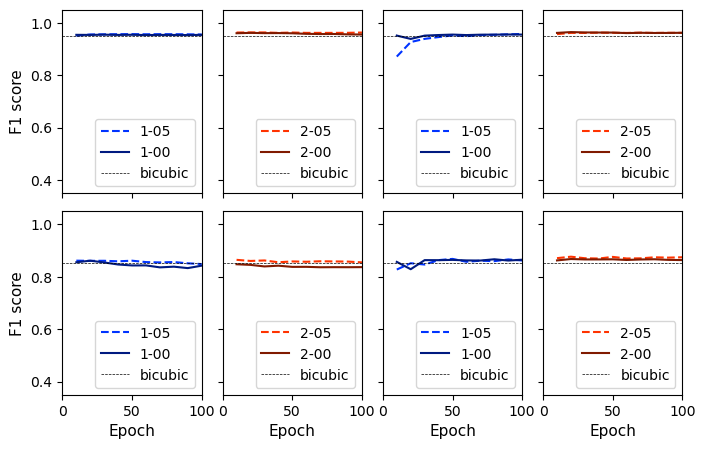

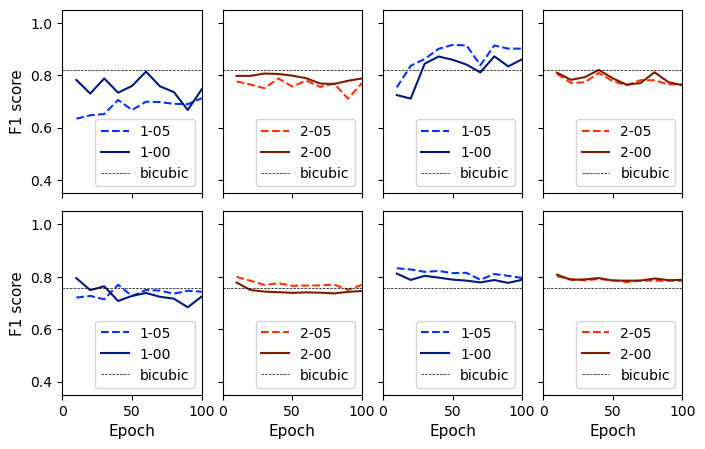

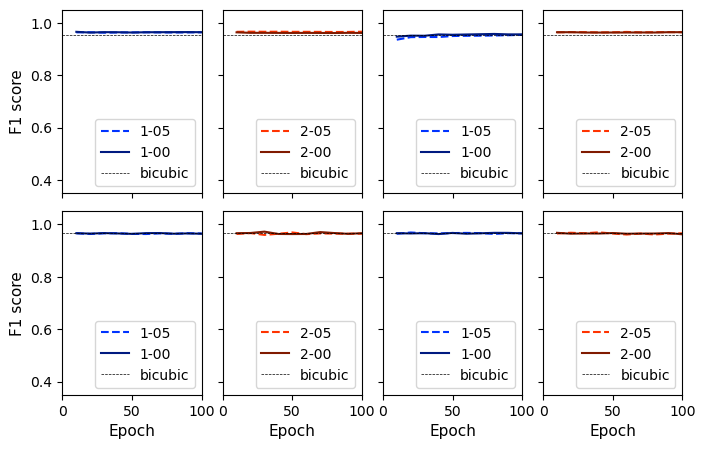

In [42]:
pairs = {
    'ws':'692_694',
    'wse':'478_479',
    'mose':'424_425',
}
for i, (mat, v1) in enumerate(scores.items()):
    pair = pairs[mat]
    f, axs = plt.subplots(2, 4, figsize=(8, 5), sharex=True)
    style = {}
    bics = [[],[]]
    for model, v2 in v1.items():
        j = 0 if model == 'dbpn' else 2
        for tune, v3 in v2.items():
            if tune == 's': continue
            step = '1-' if tune == 'f' else '2-'
            for case, v4 in v3.items():
                style['ls'] = '-' if '00' in case else '--'
                style['color'] = np.array([1,0.2,0]) if tune == 'b' else np.array([0.0,0.2,1.0])
                if '00' in case:
                    style['color'] *= 0.5 
                if pair not in v4.keys(): continue
                vals = np.array(v4[pair]).T
                ep = vals[0]
                axs[0, j + (tune == 'b')].plot(ep, vals[5], **style, label=f"{step}{case.replace('c','').replace('s','')}")
                axs[1, j + (tune == 'b')].plot(ep, vals[7], **style, label=f"{step}{case.replace('c','').replace('s','')}")
                bics[0].append(vals[1])
                bics[1].append(vals[3])
    b1, b2 = np.hstack(bics[0]).reshape(-1), np.hstack(bics[1]).reshape(-1)
    for ax in axs[0]:
        ax.axhline(np.mean(b1), ls='--', lw=0.5, color=[0,0,0], label='bicubic')
    for ax in axs[1]:
        ax.axhline(np.mean(b2), ls='--', lw=0.5, color=[0,0,0], label='bicubic')
    print(np.var(b1), np.var(b2))
    for ax in axs.reshape(-1): 
        ax.legend(loc='lower right')
    axs[0,0].set_xlim([0,100])
    for ax in axs.reshape(-1):
        ax.set_ylim([0.35,1.05])
    for ax in axs:
        for _ax in ax[1:]: _ax.set_yticklabels([])
        ax[0].set_ylabel('F1 score', fontsize=11)
    for ax in axs.T:
        ax[-1].set_xlabel('Epoch', fontsize=11)
    f.subplots_adjust(wspace=0.15, hspace=0.1)

In [22]:
def draw_cluster(ys0, ys1, ys2, 
                 HDB_params={'cluster_selection_epsilon':3}, 
                 DB_params={'eps':300}, 
                 KM_params={'n_clusters':6}, 
                 BGM_params={'n_components':8}):
    
    n1 = ys0.shape[0]
    n2 = n1 + ys1.shape[0]
    if HDB_params is not None:
        model = HDBSCAN(**HDB_params, prediction_data=True)
        model.fit(ys0)
        label_inp, _ = approximate_predict(model, ys0)
        label_true, _ = approximate_predict(model, ys1)
        mask = label_true != -1
        label_pred, _ = approximate_predict(model, ys2)
        f, axs = plt.subplots(1, 3, figsize=(12, 3))
        axs[0].pcolormesh(label_inp.reshape(40,40))
        axs[1].pcolormesh(label_true.reshape(80,80))
        axs[2].pcolormesh(label_pred.reshape(80,80))
        for ax in axs: ax.axis('off')
        print('HDBSCAN: {:.4f} / {:.4f}'.format(
            f1_score(label_true[mask], label_pred[mask], average='micro'), 
            accuracy_score(label_true[mask], label_pred[mask])))
        print(np.sum(label_inp == -1)/1600, np.sum(label_true == -1)/6400, np.sum(label_pred == -1)/6400)
        
    if DB_params is not None:
        model = DBSCAN(eps=300)
        model.fit(np.vstack([ys0, ys1, ys2]))
        f, axs = plt.subplots(1, 3, figsize=(12, 3))
        label_inp, label_true, label_pred = model.labels_[:n1], model.labels_[n1:n2], model.labels_[n2:]
        axs[0].pcolormesh(label_inp.reshape(40,40))
        axs[1].pcolormesh(label_true.reshape(80,80))
        axs[2].pcolormesh(label_pred.reshape(80,80))
        for ax in axs: ax.axis('off')
        print('DBSCAN: {:.4f} / {:.4f}'.format(
            f1_score(label_true, label_pred, average='micro'), 
            accuracy_score(label_true, label_pred)))

    if KM_params is not None:
        model = KMeans(**KM_params)
        model.fit(ys0)
        label_true = model.predict(ys1)
        label_pred = model.predict(ys2)
        f, axs = plt.subplots(1, 3, figsize=(12, 3))
        axs[0].pcolormesh(model.labels_.reshape(40,40))
        axs[1].pcolormesh(label_true.reshape(80,80))
        axs[2].pcolormesh(label_pred.reshape(80,80))
        for ax in axs: ax.axis('off')
        print('KMeans: {:.4f} / {:.4f}'.format(
            f1_score(label_true, label_pred, average='micro'), 
            accuracy_score(label_true, label_pred)))
        
    if BGM_params is not None:
        model = BayesianGaussianMixture(**BGM_params)
        model.fit(np.vstack([ys0, ys1, ys2]))
#        model.fit(ys2)
        labels = model.predict(np.vstack([ys0, ys1, ys2]))
        label_inp, label_true, label_pred = labels[:n1], labels[n1:n2], labels[n2:]
        f, axs = plt.subplots(1, 3, figsize=(12, 3))
        axs[0].pcolormesh(label_inp.reshape(40,40))
        axs[1].pcolormesh(label_true.reshape(80,80))
        axs[2].pcolormesh(label_pred.reshape(80,80))
        for ax in axs: ax.axis('off')
        print('BGMM: {:.4f} / {:.4f}'.format(
            f1_score(label_true, label_pred, average='micro'), 
            accuracy_score(label_true, label_pred)))

HDBSCAN: 0.9627 / 0.9627
0.1425 0.17890625 0.1303125
KMeans: 0.8672 / 0.8672
BGMM: 0.7761 / 0.7761
HDBSCAN: 0.9498 / 0.9498
0.1425 0.17890625 0.1496875
KMeans: 0.8541 / 0.8541
BGMM: 0.7578 / 0.7578


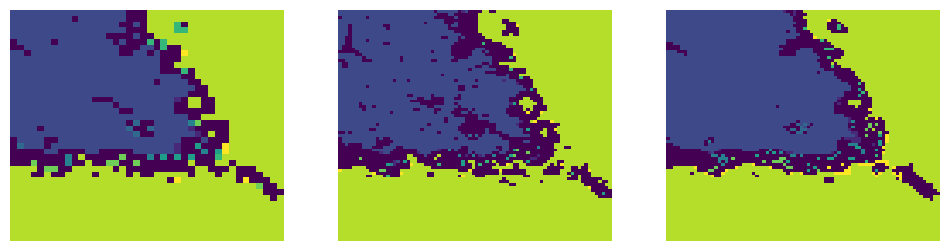

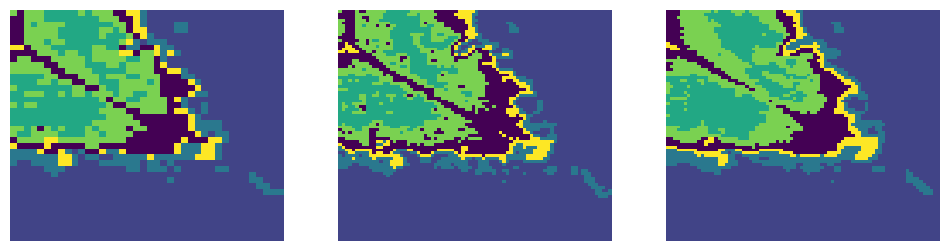

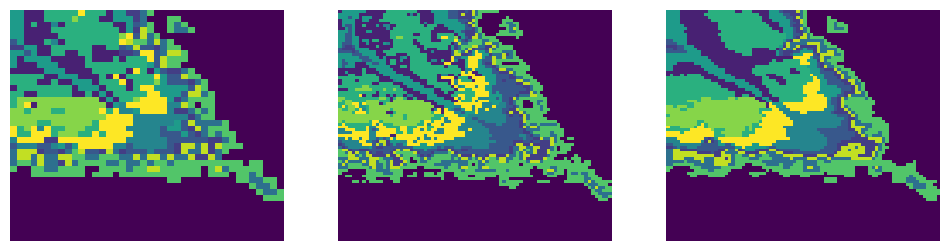

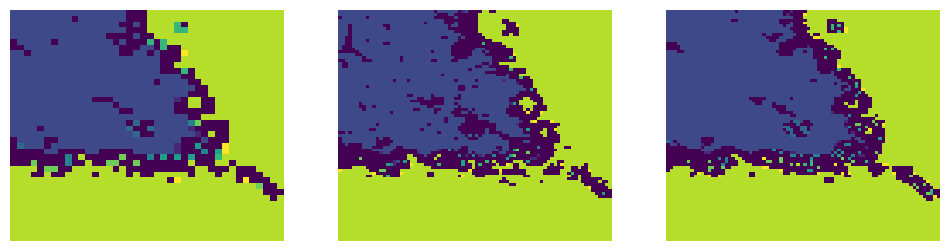

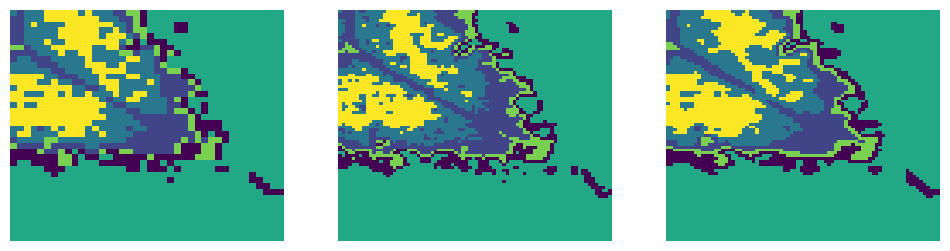

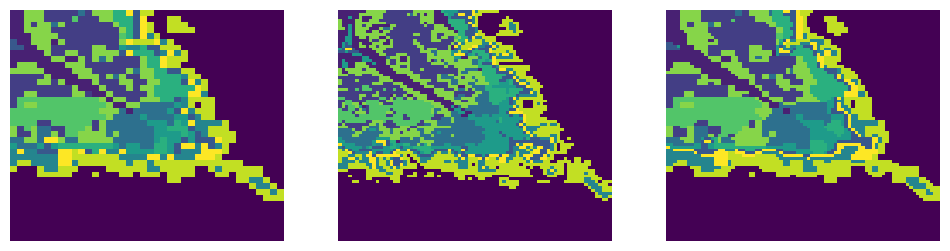

In [23]:
x0, ys0 = origs['692']
x1, ys1 = origs['694']
#mat = np.loadtxt('/home/jhyang/WORKSPACES/MODELS/super_res/pl/s84_cvd_ws2/dbpn/basetune/s05_2x/00100.valid/692_2x_694.txt').T
#mat = np.loadtxt('/home/jhyang/WORKSPACES/MODELS/super_res/pl/s84_cvd_ws2/dbpn/legacy/basetune/s05_2x_40/00070.valid/692_2x_694.txt').T
#x2, ys2 = mat[0], mat[1:]
x, ys0, ys1, ys2 = outputs['ws']['rbpn']['b']['s00']['692_694'][50]
n1, n2 = ys0.shape[0], ys0.shape[0] + ys1.shape[0]
draw_cluster(ys0, ys1, ys2, DB_params=None, BGM_params={'n_components':12, 'tol':0.1})



In [10]:
x, ys0, ys1, ys2 = outputs['ws']['rbpn']['b']['s00']['692_694'][50]
_, ys0, ys1, ys2 = outputs['wse']['rbpn']['f']['s05']['478_479'][100]
x, ys0, ys1, ys2 = outputs['mose']['dbpn']['b']['s00']['424_425'][100]

tsne = TSNE(n_components=2, init='pca', learning_rate='auto')
tout = tsne.fit_transform(np.vstack([ys0, ys1, ys2]))


/home/jhyang/anaconda3/envs/image/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[]

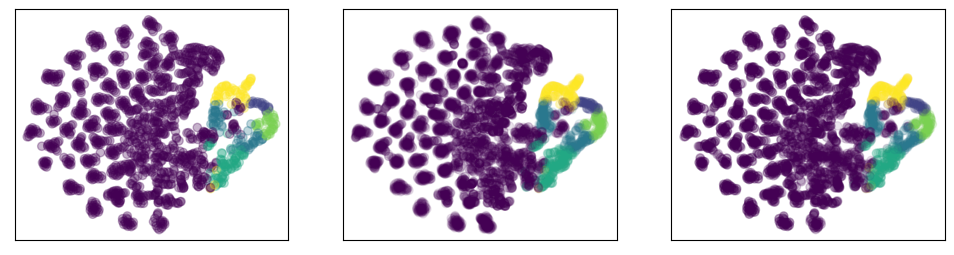

In [11]:
n1 = ys0.shape[0]
n2 = n1 + ys1.shape[0]
km = KMeans(n_clusters=6)
km.fit(ys0)
cs = km.predict(np.vstack([ys0, ys1, ys2]))
v0, v1, v2 = tout[:n1], tout[n1:n2], tout[n2:]
c0, c1, c2 = cs[:n1], cs[n1:n2], cs[n2:]
f, axs = plt.subplots(1,3,figsize=(12, 3), sharex=True, sharey=True)
axs[0].scatter(*v0.T, c=c0, alpha=0.3)
axs[1].scatter(*v1.T, c=c1, alpha=0.1)
axs[2].scatter(*v2.T, c=c2, alpha=0.1)
axs[0].set_xticklabels([])
axs[0].set_xticks([])
axs[0].set_yticklabels([])
axs[0].set_yticks([])

KMeans: 0.9678 / 0.9678


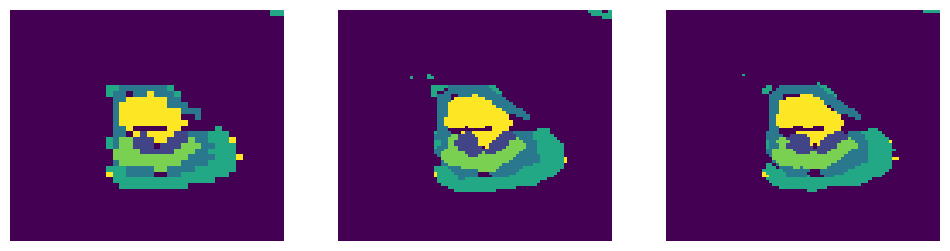

In [12]:
label_true = km.predict(ys1)
label_pred = km.predict(ys2)
f, axs = plt.subplots(1, 3, figsize=(12, 3))
axs[0].pcolormesh(km.labels_.reshape(40,40))
axs[1].pcolormesh(label_true.reshape(80,80))
axs[2].pcolormesh(label_pred.reshape(80,80))
for ax in axs: ax.axis('off')
print('KMeans: {:.4f} / {:.4f}'.format(
    f1_score(label_true, label_pred, average='micro'), 
    accuracy_score(label_true, label_pred)))


HDBSCAN: 0.9613 / 0.9613
0.214375 0.23203125 0.2228125
KMeans: 0.9630 / 0.9630
BGMM: 0.9478 / 0.9478


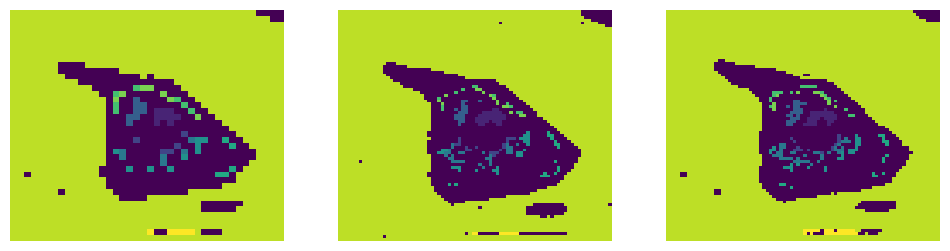

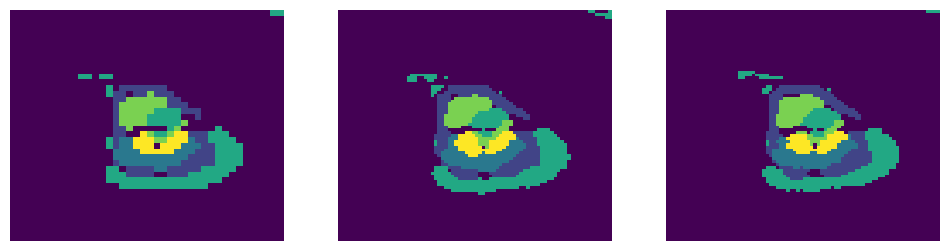

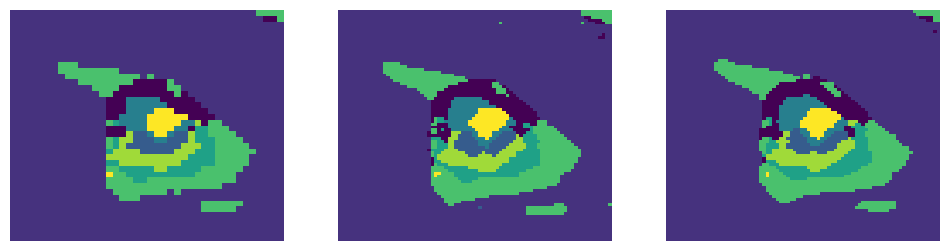

In [ ]:
x, ys0, ys1, ys2 = outputs['mose']['dbpn']['b']['s00']['424_425'][100]
draw_cluster(ys0, ys1, ys2, DB_params=None, BGM_params={'n_components':12, 'tol':0.1})

/home/jhyang/anaconda3/envs/image/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[]

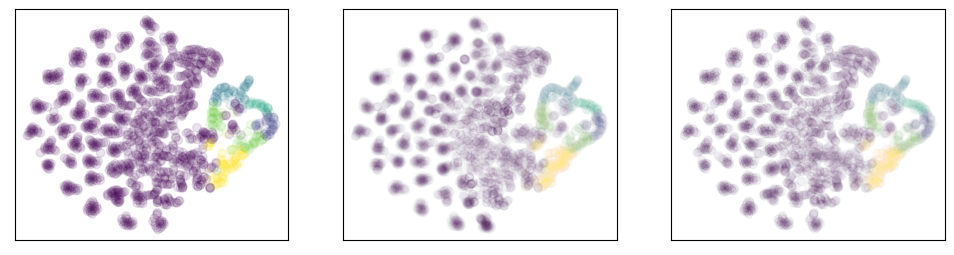

In [68]:
x, ys0, ys1, ys2 = outputs['mose']['dbpn']['b']['s00']['424_425'][100]

km = KMeans(n_clusters=6)
km.fit(ys0)
cs = km.predict(np.vstack([ys0, ys1, ys2]))
tsne = TSNE(n_components=2, init='pca', learning_rate='auto')
tout = tsne.fit_transform(np.vstack([ys0, ys1, ys2]))

[]

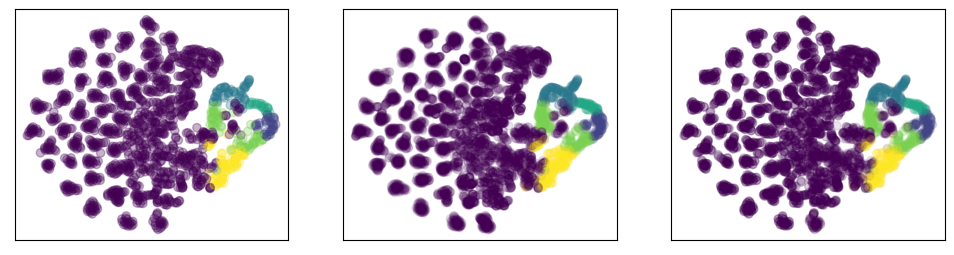

In [73]:
v0, v1, v2 = tout[:n1], tout[n1:n2], tout[n2:]
c0, c1, c2 = cs[:n1], cs[n1:n2], cs[n2:]
f, axs = plt.subplots(1,3,figsize=(12, 3), sharex=True, sharey=True)
axs[0].scatter(*v0.T, c=c0, alpha=0.3)
axs[1].scatter(*v1.T, c=c1, alpha=0.1)
axs[2].scatter(*v2.T, c=c2, alpha=0.1)
axs[0].set_xticklabels([])
axs[0].set_xticks([])
axs[0].set_yticklabels([])
axs[0].set_yticks([])

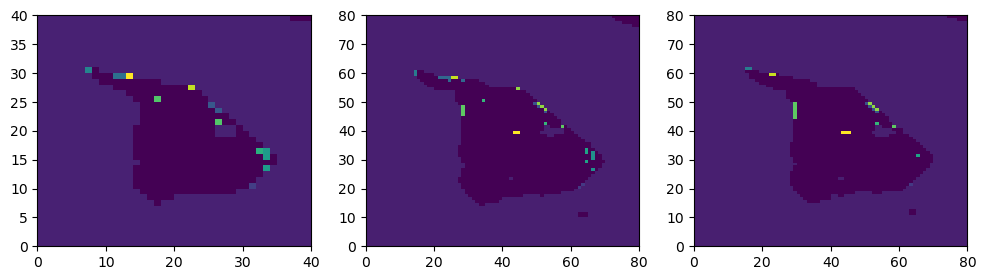

In [310]:
x0, ys0 = origs['424']
x1, ys1 = origs['425']
x2, ys2 = outputs['mose']['dbpn']['b']['s00']['424_425'][100]
inp, tgt, _ = preprocessing(x0, x2, ys0, ys1, ys2)

model = DBSCAN(eps=1500)
model.fit(np.vstack([inp, tgt, ys2]))
f, axs = plt.subplots(1, 3, figsize=(12, 3))
axs[0].pcolormesh(model.labels_[:n1].reshape(40,40))
axs[1].pcolormesh(model.labels_[n1:n2].reshape(80,80))
axs[2].pcolormesh(model.labels_[n2:].reshape(80,80))

HDBSCAN: 0.9014 / 0.9014
0.565 0.7559375 0.353125
KMeans: 0.8002 / 0.8002
BGMM: 0.2641 / 0.2641


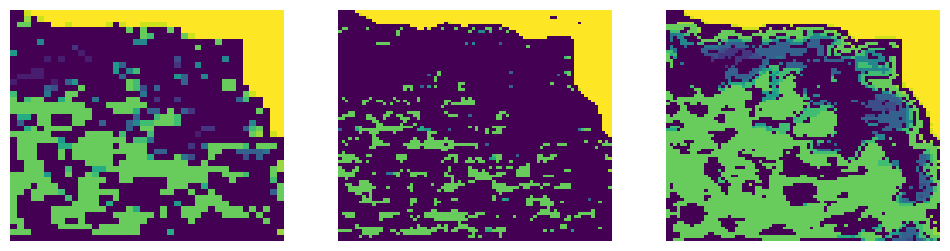

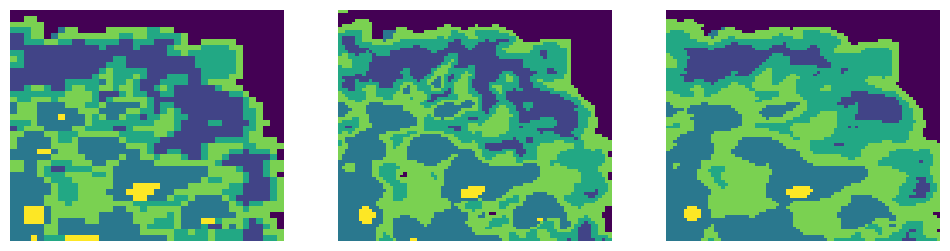

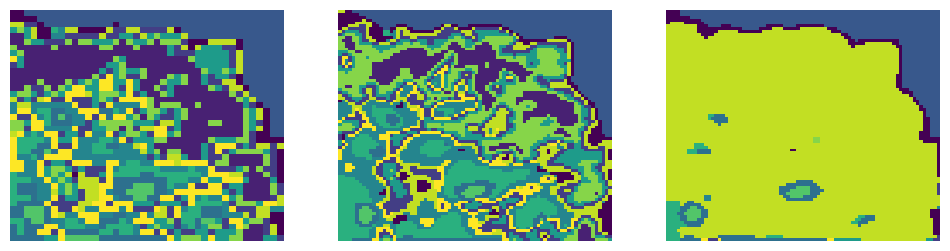

In [47]:
_, ys0, ys1, ys2 = outputs['wse']['rbpn']['f']['s05']['478_479'][100]

draw_cluster(ys0, ys1, ys2, DB_params=None, BGM_params={'n_components':12, 'tol':0.1})

/home/jhyang/anaconda3/envs/image/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[]

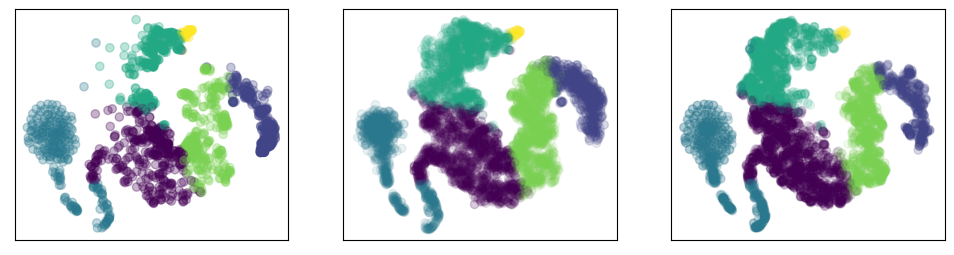

In [62]:
km = KMeans(n_clusters=6)
km.fit(ys0)
cs = km.predict(np.vstack([ys0, ys1, ys2]))
tsne = TSNE(n_components=2, init='pca', learning_rate='auto')
tout = tsne.fit_transform(np.vstack([ys0, ys1, ys2]))

v0, v1, v2 = tout[:n1], tout[n1:n2], tout[n2:]
c0, c1, c2 = cs[:n1], cs[n1:n2], cs[n2:]
f, axs = plt.subplots(1,3,figsize=(12, 3), sharex=True, sharey=True)
axs[0].scatter(*v0.T, c=c0, alpha=0.3)
axs[1].scatter(*v1.T, c=c1, alpha=0.1)
axs[2].scatter(*v2.T, c=c2, alpha=0.1)
axs[0].set_xticklabels([])
axs[0].set_xticks([])
axs[0].set_yticklabels([])
axs[0].set_yticks([])

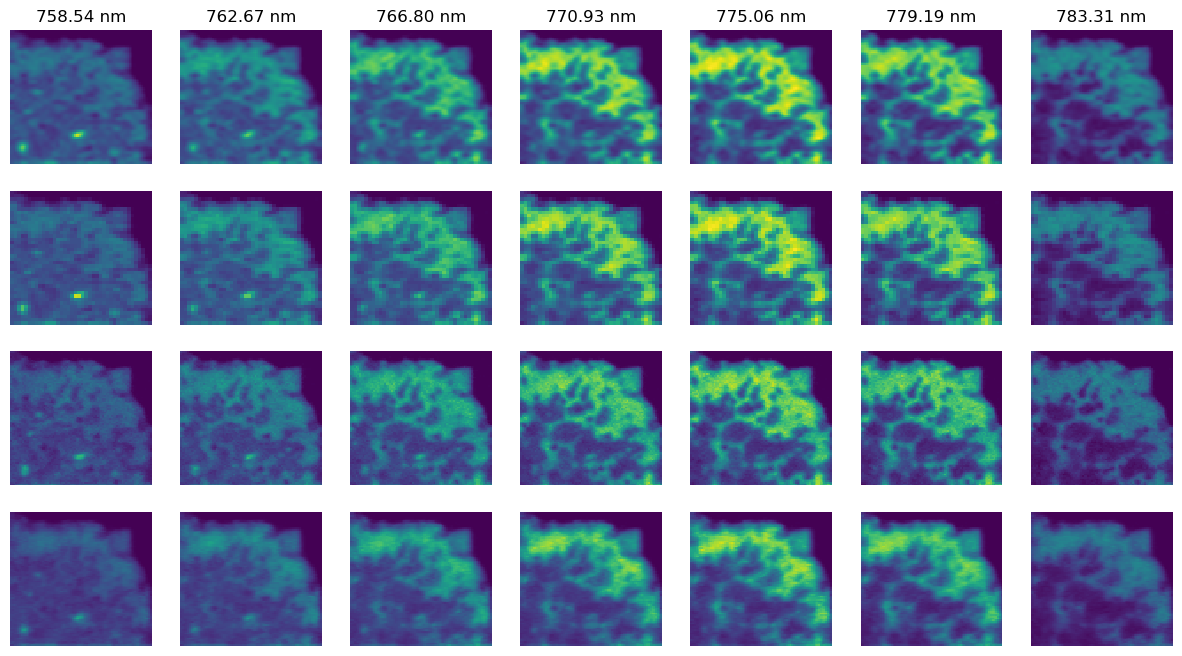

In [66]:
x, ys0, ys1, ys2 = outputs['wse']['rbpn']['b']['s05']['478_479'][100]
bic = interpolate(torch.from_numpy(ys0.T.reshape(1, -1, 40, 40)), scale_factor=2, mode='bicubic').numpy().reshape(-1,6400).T
_bic = bic.reshape(80,80,-1)
_ys0 = ys0.reshape(40,40,-1)
_ys1 = ys1.reshape(80,80,-1)
_ys2 = ys2.reshape(80,80,-1)
#idxs = [100, 120, 150, 200, 230]
idxs = [250, 275, 300, 325, 350, 375, 400]
f, axs = plt.subplots(4, len(idxs), figsize=(15, 8))
for ax, idx in zip(axs.T, idxs):
    ax[0].set_title(f'{x[idx]:.2f} nm')
    ax[0].pcolormesh(_bic[..., idx], vmin=np.min(ys2), vmax=np.max(ys2))
    ax[1].pcolormesh(_ys0[..., idx], vmin=np.min(ys2), vmax=np.max(ys2))
    ax[2].pcolormesh(_ys1[..., idx], vmin=np.min(ys2), vmax=np.max(ys2))
    ax[3].pcolormesh(_ys2[..., idx], vmin=np.min(ys2), vmax=np.max(ys2))
    for _ax in ax: _ax.axis('off')

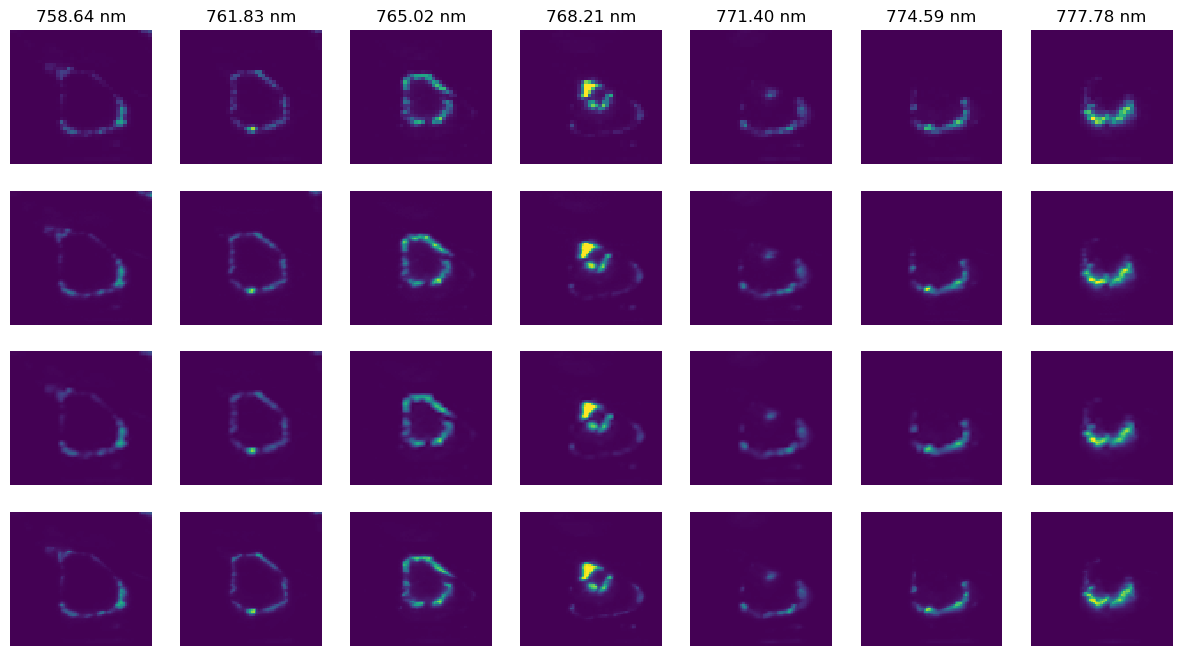

In [176]:
x2, ys2 = outputs['mose']['dbpn']['f']['s00']['424_425'][100]
x0, ys0 = origs['424']
x1, ys1 = origs['425']
inp, tgt, _ = preprocessing(x0, x2, ys0, ys1, ys2)
bic = torch.nn.functional.interpolate(torch.from_numpy(inp.T).reshape(1,-1,40,40), scale_factor=2, mode='bicubic')
bic = bic.numpy().squeeze().transpose(1,2,0)

_ys0 = inp.reshape(40,40,-1)
_ys1 = tgt.reshape(80,80,-1)
_ys2 = ys2.reshape(80,80,-1)
#idxs = [100, 120, 150, 200, 230]
idxs = [75, 100, 125, 150, 175, 200, 225]
f, axs = plt.subplots(4, len(idxs), figsize=(15, 8))
for ax, idx in zip(axs.T, idxs):
    ax[0].set_title(f'{x2[idx]:.2f} nm')
    ax[0].pcolormesh(_ys0[..., idx], vmin=np.min(ys2), vmax=np.max(ys2))
    ax[1].pcolormesh(_ys1[..., idx], vmin=np.min(ys2), vmax=np.max(ys2))
    ax[2].pcolormesh(bic[..., idx], vmin=np.min(ys2), vmax=np.max(ys2))
    ax[3].pcolormesh(_ys2[..., idx], vmin=np.min(ys2), vmax=np.max(ys2))
    for _ax in ax: _ax.axis('off')

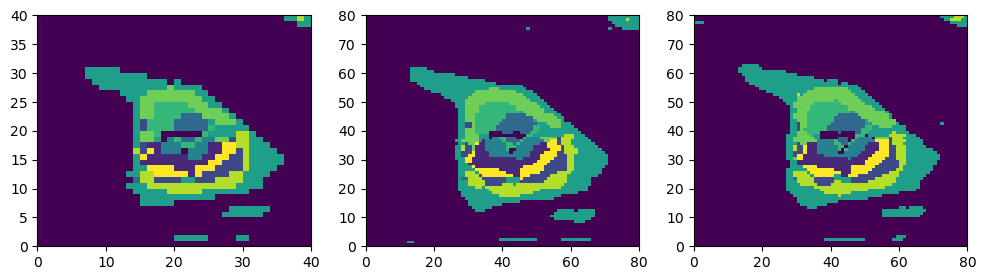

In [217]:
from sklearn.mixture import BayesianGaussianMixture
model = BayesianGaussianMixture(n_components=10)
model.fit(np.vstack([inp, tgt, ys2]))
#model.fit(inp)

label_inp = model.predict(inp)
label_tgt = model.predict(tgt)
label_pred = model.predict(ys2)

f, axs = plt.subplots(1, 3, figsize=(12, 3))
axs[0].pcolormesh(label_inp.reshape(40,40))
axs[1].pcolormesh(label_tgt.reshape(80,80))
axs[2].pcolormesh(label_pred.reshape(80,80))

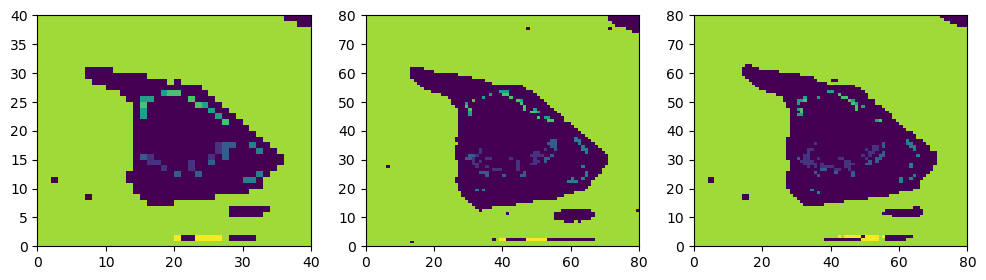

In [215]:
model = HDBSCAN(cluster_selection_epsilon=1e7, prediction_data=True)
#model.fit(np.vstack([inp, ys2]))
model.fit(inp)

label_inp, _ = approximate_predict(model, inp)
label_tgt, _ = approximate_predict(model, tgt)
label_pred, _ = approximate_predict(model, ys2)

f, axs = plt.subplots(1, 3, figsize=(12, 3))
axs[0].pcolormesh(label_inp.reshape(40,40))
axs[1].pcolormesh(label_tgt.reshape(80,80))
axs[2].pcolormesh(label_pred.reshape(80,80))

In [302]:
i1, i2 = 692, 694
root = '/home/jhyang/WORKSPACES/MODELS/super_res/pl/s84_cvd_ws2/dbpn/basetune/s05_2x_40/00070.valid.pkl'
data = pickle.load(open(root, 'rb'))[f'({i1}, {i2})']
vmin, vmax, x_, yp = data['vmin'], data['vmax'], data['x'], data['pred']
yp = yp[:, 0].transpose(1, 2, 0).reshape(-1, x_.shape[0])
yp = denorm_spectrum(yp, vmin=vmin, vmax=vmax)
x, y1_ = read_spectrum(i1, root='/home/jhyang/WORKSPACES/DATA/2D/pl_postech/spectrum/')
x, y2_ = read_spectrum(i2, root='/home/jhyang/WORKSPACES/DATA/2D/pl_postech/spectrum/')
mask = np.sum(np.abs(x.reshape(-1,1) - x_.reshape(1,-1)) < np.mean(x[1:] - x[:-1])*0.5, axis=1).astype(bool)
y1 = y1_.reshape(-1, x.shape[0])[:, mask]
y2 = y2_.reshape(-1, x.shape[0])[:, mask]
ys = np.vstack([y1, y2, yp])
n1 = y1.shape[0]
n2 = n1 + y2.shape[0]

hdbscan = HDBSCAN(cluster_selection_epsilon=3, prediction_data=True)
hdbscan.fit(y1)
hdbly = hdbscan.labels_
hdb_predicted_labels, strengths = approximate_predict(hdbscan, ys)
hdbly1, hdbly2, hdblyp = hdb_predicted_labels[:n1], hdb_predicted_labels[n1:n2], hdb_predicted_labels[n2:]
str1, str2, strp = strengths[:n1], strengths[n1:n2], strengths[n2:]
print(set(hdbly), set(hdbly1), set(hdbly2), set(hdblyp))
#hdbscan.approximate_predict
#hdbscan.
metric = '{:.3f} / {:.3f} / {:.3f}'.format(r2_score(hdbly2, hdblyp), f1_score(hdbly2, hdblyp, average='weighted'), accuracy_score(hdbly2, hdblyp))
print(metric)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1} {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1} {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1} {0, 1, 2, 3, 4, 5, 6, 8, -1}
0.795 / 0.890 / 0.892


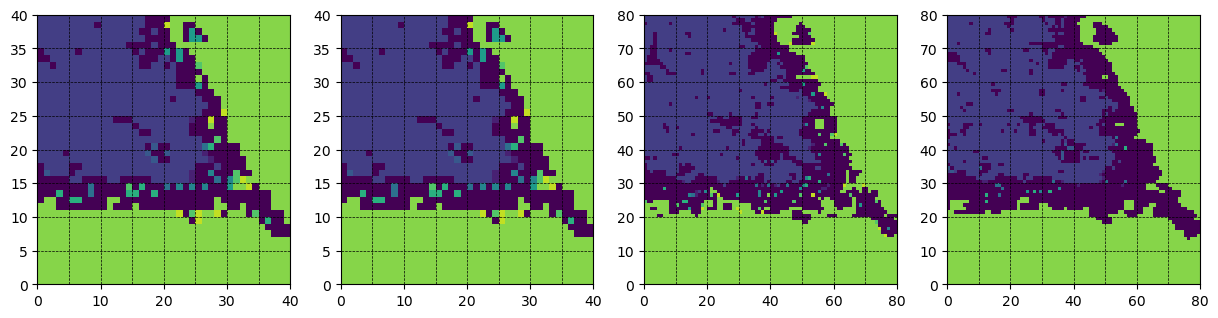

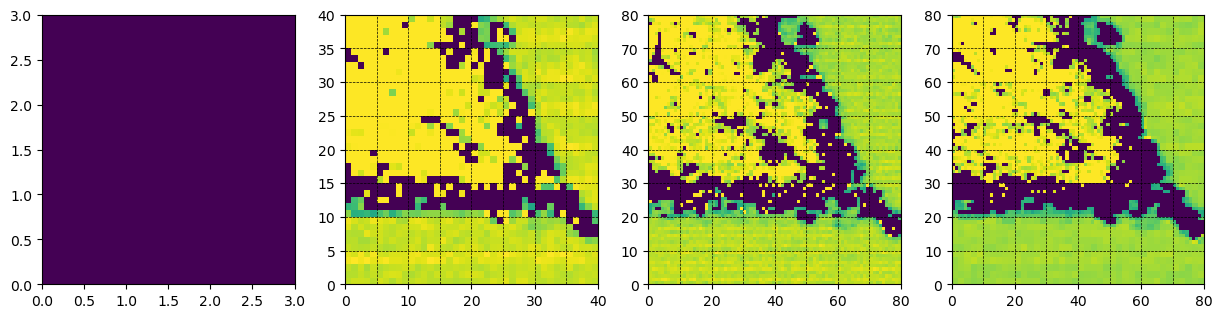

In [250]:
f, axs = plt.subplots(1, 4, figsize=(15, 3.5))
for ax, lbl in zip(axs, [hdbly, hdbly1, hdbly2, hdblyp]):
    n = np.sqrt(lbl.shape[0]).astype(int)
    ax.pcolormesh(lbl.reshape(n,n), vmin=-1, vmax=10)
#    ax.axis('off')
    for i in range(1,8):
        j = i * n // 8
        ax.axvline(j, ls='--', color=[0,0,0], lw=0.5)
        ax.axhline(j, ls='--', color=[0,0,0], lw=0.5)
f, axs = plt.subplots(1, 4, figsize=(15, 3.5))
for ax, lbl in zip(axs, [np.zeros(9), str1, str2, strp]):
    n = np.sqrt(lbl.shape[0]).astype(int)
    ax.pcolormesh(lbl.reshape(n,n), vmin=0, vmax=1)
#    ax.axis('off')    
    for i in range(1,8):
        j = i * (n // 8)
        ax.axvline(j, ls='--', color=[0,0,0], lw=0.5)
        ax.axhline(j, ls='--', color=[0,0,0], lw=0.5)    

## K-MEANS

In [310]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(y1)
km_predicted_labels = kmeans.predict(ys)
kmly1, kmly2, kmlyp = km_predicted_labels[:n1], km_predicted_labels[n1:n2], km_predicted_labels[n2:]
metric = '{:.3f} / {:.3f} / {:.3f}'.format(r2_score(kmly2, kmlyp), f1_score(kmly2, kmlyp, average='weighted'), accuracy_score(kmly2, kmlyp))
print(metric)

0.587 / 0.899 / 0.901


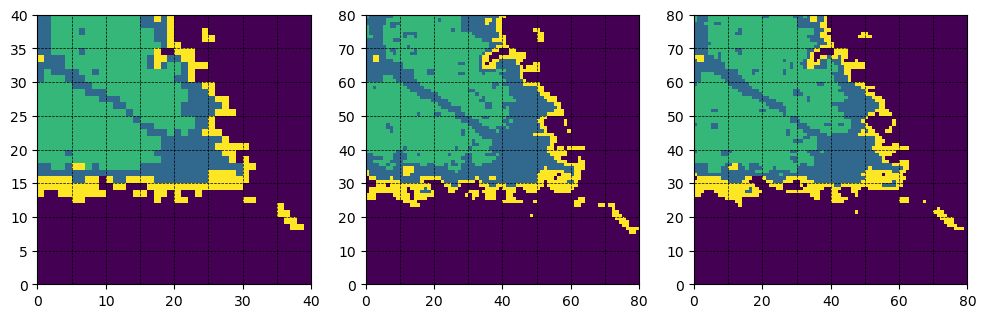

In [312]:
f, axs = plt.subplots(1, 3, figsize=(12, 3.5))
for ax, lbl in zip(axs, [kmly1, kmly2, kmlyp]):
    n = np.sqrt(lbl.shape[0]).astype(int)
    ax.pcolormesh(lbl.reshape(n,n), vmin=0, vmax=n_clusters-1)
#    ax.axis('off')
    for i in range(1,8):
        j = i * n // 8
        ax.axvline(j, ls='--', color=[0,0,0], lw=0.5)
        ax.axhline(j, ls='--', color=[0,0,0], lw=0.5)

## TSNE - visualization

In [193]:
n1 = inp.shape[0]
n2 = inp.shape[0] + tgt.shape[0]

n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(inp)
km_predicted_labels = kmeans.predict(np.vstack([inp, tgt, ys2]))
kmly1, kmly2, kmlyp = km_predicted_labels[:n1], km_predicted_labels[n1:n2], km_predicted_labels[n2:]
metric = '{:.3f} / {:.3f} / {:.3f}'.format(r2_score(kmly2, kmlyp), f1_score(kmly2, kmlyp, average='weighted'), accuracy_score(kmly2, kmlyp))
print(metric)

0.791 / 0.963 / 0.963


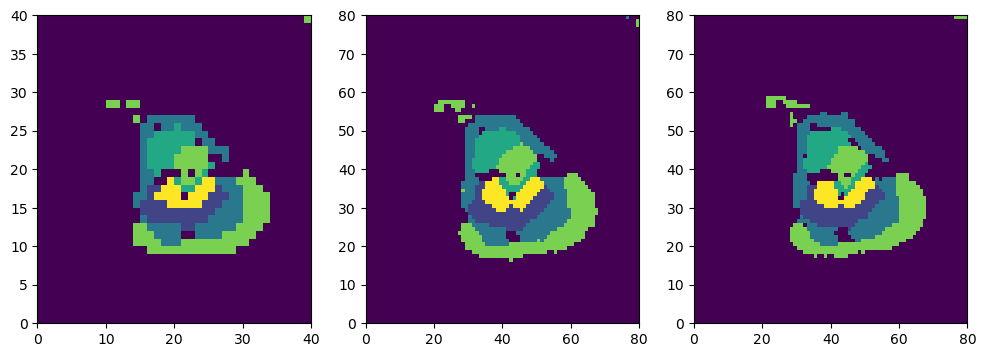

In [194]:
f, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].pcolormesh(kmly1.reshape(40,40))
axs[1].pcolormesh(kmly2.reshape(80,80))
axs[2].pcolormesh(kmlyp.reshape(80,80))

In [174]:
tsne = TSNE(init='pca', learning_rate='auto')
km   = KMeans(n_clusters=6)
km.fit(ys0)
km_predicted_labels = km.predict(np.vstack([ys0, ys1, ys2]))
out = tsne.fit_transform(np.vstack([ys0, ys1, ys2]))
n1 = ys0.shape[0]
n2 = n1 + ys1.shape[0]

/home/jhyang/anaconda3/envs/image/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


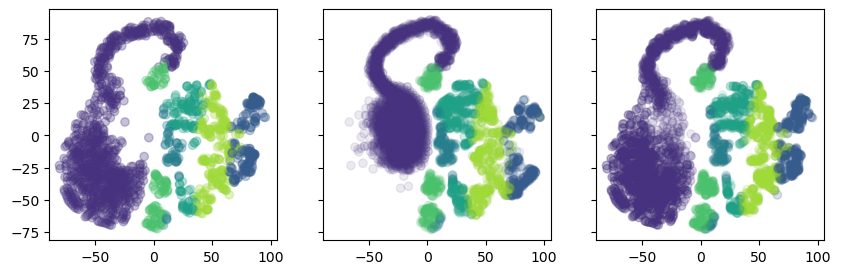

In [176]:
f, axs = plt.subplots(1, 3, figsize=(10, 3), sharex=True, sharey=True)
axs[0].scatter(*out[:n1].T, c=km_predicted_labels[:n1], vmin=-1, vmax=6, alpha=0.3)
axs[1].scatter(*out[n1:n2].T, c=km_predicted_labels[n1:n2], vmin=-1, vmax=6, alpha=0.1)
axs[2].scatter(*out[n2:].T, c=km_predicted_labels[n2:], vmin=-1, vmax=6, alpha=0.1)

In [158]:
dbscan = DBSCAN(eps=30, min_samples=5)
model = dbscan.fit(ys)
dbly1, dbly2, dblyp = dbscan.labels_[:n1], dbscan.labels_[n1:n2], dbscan.labels_[n2:]
set(dbly1), set(dbly2), set(dblyp)


({-1, 0}, {-1, 0, 1}, {2})

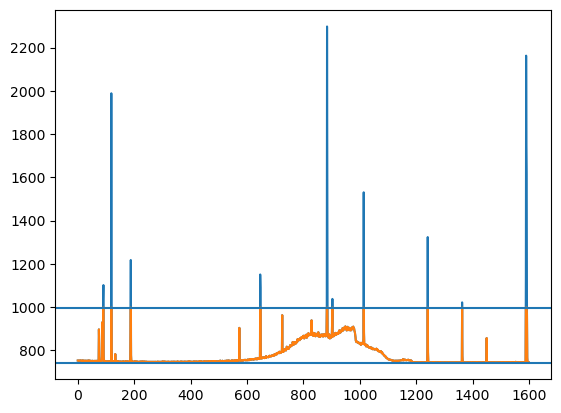

In [66]:
plt.plot(np.max(ys.reshape(x.shape[0], -1), axis=1))
plt.plot(np.max(np.clip(ys.reshape(x.shape[0], -1), vmin, vmax), axis=1))
plt.axhline(vmax)
plt.axhline(vmin)

In [69]:
vmax, vmin, vmax-vmin

(997.8268615223618, 742.8268615223618, 255.0)

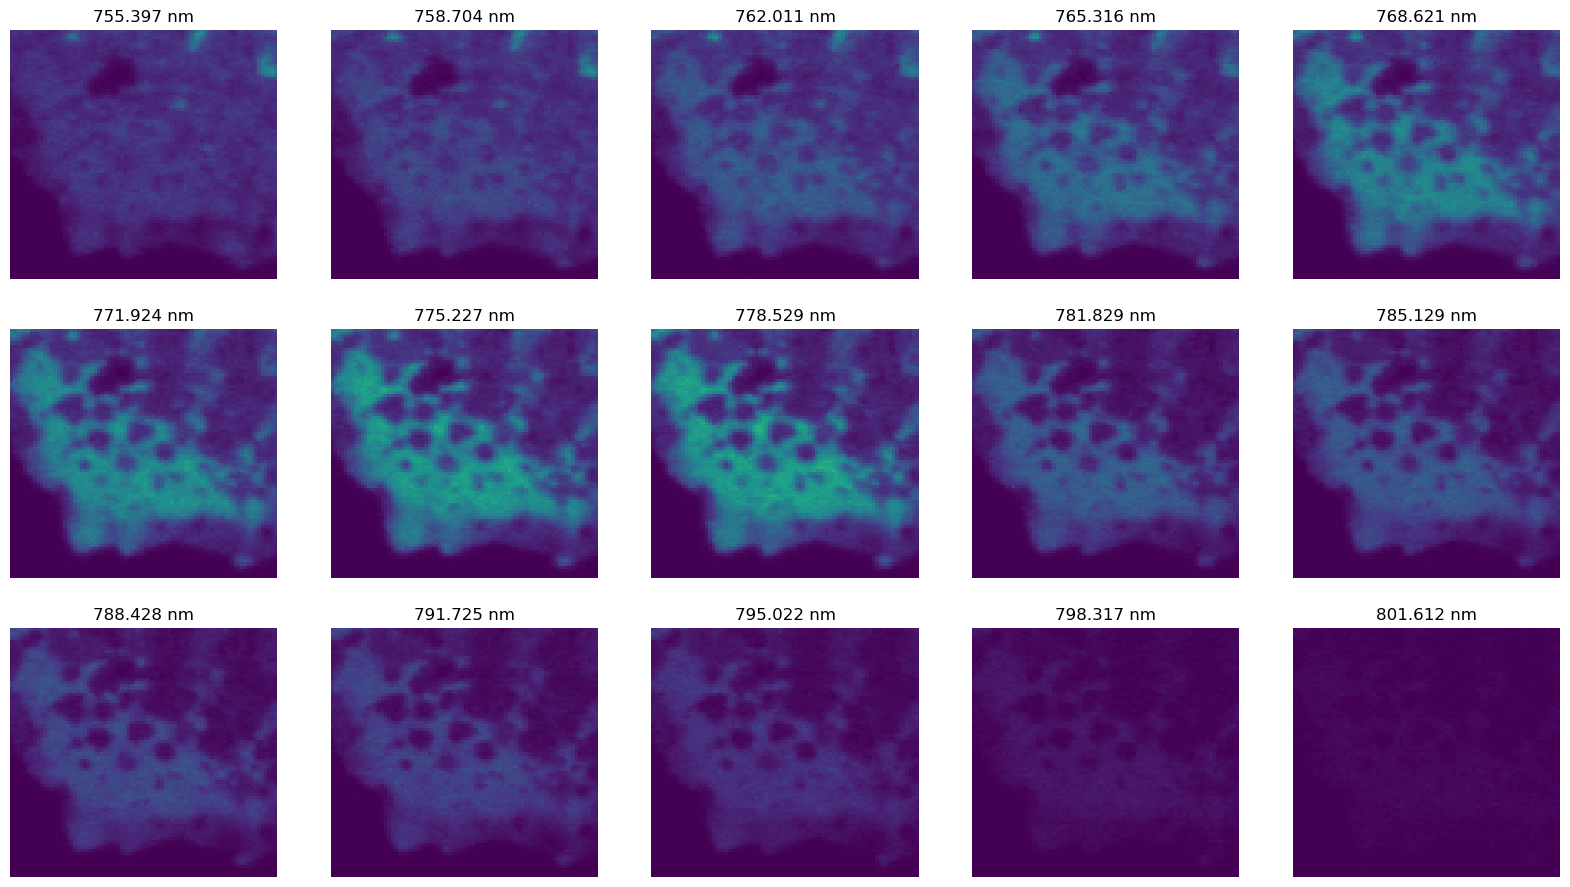

In [72]:
x, ys = read_spectrum(472)
vmin, vmax, nys = norm_spectrum(ys, ref=ys, mode='histogram')
var = np.var(nys.reshape(x.shape[0], -1), axis=1)
i0 = np.argmax(var)
s = 20
idxs = [i0 - 7*s + i*s for i in range(7)] + [i0 + i*s for i in range(8)]
f, axs = plt.subplots(3, 5, figsize=(20, 11))
for i, ax in zip(idxs, axs.reshape(-1)):
    ax.pcolormesh(nys[i], vmin=0, vmax=1)
    ax.set_title(f'{x[i]} nm')
    ax.axis('off')
    

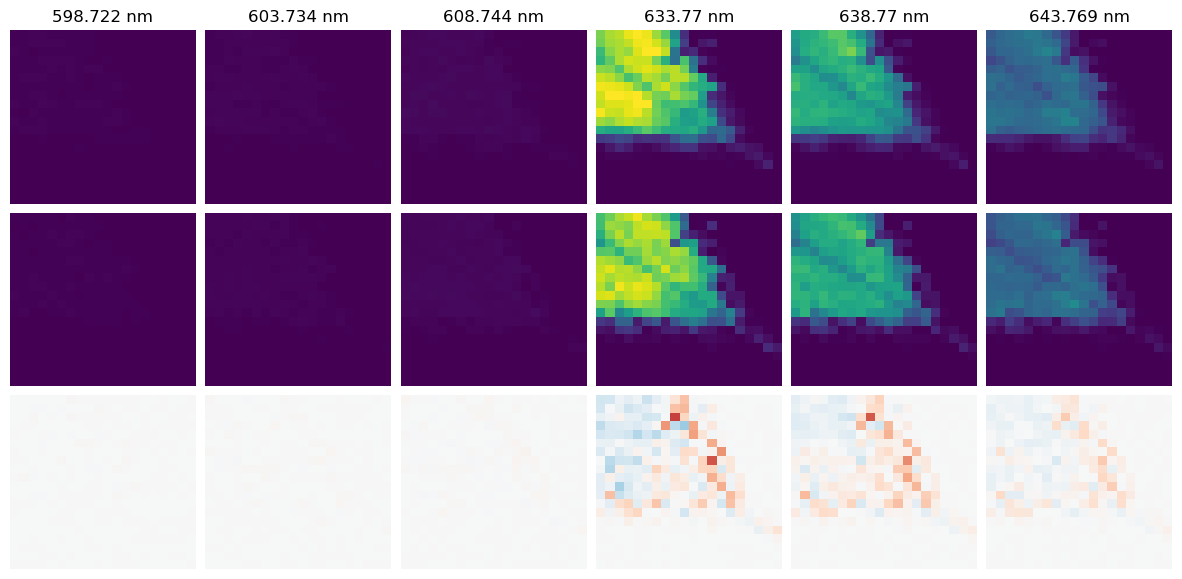

In [112]:
x0, ys0 = read_spectrum(691)
x1, ys1 = read_spectrum(692)
x2, ys2 = read_spectrum(694)
vmin, vmax, nys0 = norm_spectrum(ys0, ref=ys0, mode='histogram')
_, _, nys1 = norm_spectrum(ys1, vmin=vmin, vmax=vmax, mode='minmax')
_, _, nys2 = norm_spectrum(ys2, vmin=vmin, vmax=vmax, mode='minmax')
var = np.var(nys0.reshape(x0.shape[0], -1), axis=1)
i0 = np.argmax(var)
s = 30
idxs = [i0 - 7*s + i*s for i in range(3)] + [i0 + i*s for i in range(3)]

bys0 = interpolate(torch.from_numpy(nys1.reshape(1, -1, 40, 40)), scale_factor=0.5, mode='bicubic').numpy().reshape(-1,20,20)


f, axs = plt.subplots(3, 6, figsize=(15, 7))
for i, ax in zip(idxs, axs.T):
    ax[0].pcolormesh(nys0[i], vmin=0, vmax=1)
    ax[1].pcolormesh(bys0[i], vmin=0, vmax=1)
#    ax[2].pcolormesh(nys1[i], vmin=0, vmax=1)
    ax[2].pcolormesh(nys0[i] - bys0[i], vmin=-0.5, vmax=0.5, cmap='RdBu')
    ax[0].set_title(f'{x0[i]} nm')
    for a in ax: a.axis('off')
f.subplots_adjust(wspace=0.05, hspace=0.05)

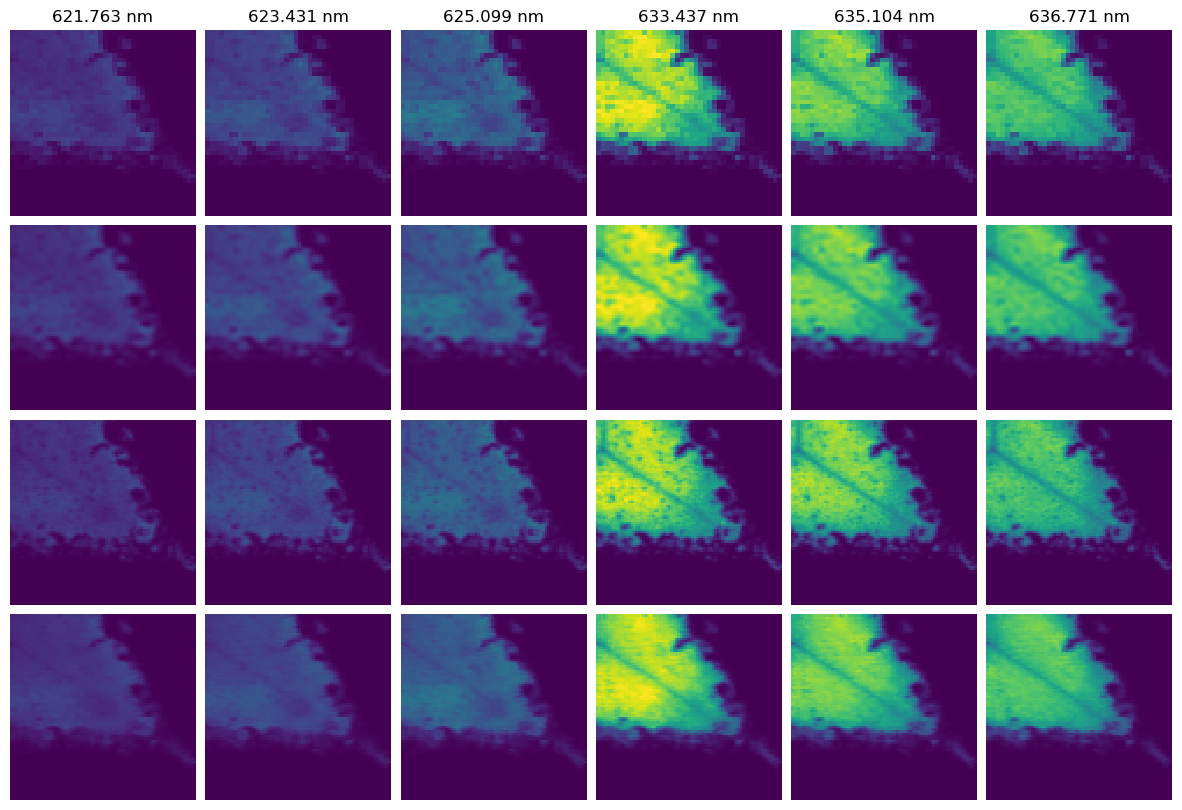

In [101]:
#x0, ys0 = read_spectrum(473)
#x1, ys1 = read_spectrum(474)
#x2, ys2 = read_spectrum(476)
x, nys0, nys1, nys2 = outputs['ws']['dbpn']['b']['s05']['692_694'][100]
bic = interpolate(torch.from_numpy(nys0.T.reshape(1, -1, 40, 40)), scale_factor=2, mode='bicubic').numpy().reshape(-1,6400).T

#vmin, vmax, nys0 = norm_spectrum(ys0, ref=ys0, mode='histogram')
#_, _, nys1 = norm_spectrum(ys1, vmin=vmin, vmax=vmax, mode='minmax')
#_, _, nys2 = norm_spectrum(ys2, vmin=vmin, vmax=vmax, mode='minmax')
var = np.var(nys0.T.reshape(x.shape[0], -1), axis=1)
i0 = np.argmax(var)
s = 10
idxs = [i0 - 7*s + i*s for i in range(3)] + [i0 + i*s for i in range(3)]
f, axs = plt.subplots(4, 6, figsize=(15, 10))
for i, ax in zip(idxs, axs.T):
    ax[0].pcolormesh(nys0.T.reshape(-1, 40, 40)[i], vmin=0, vmax=1)
    ax[1].pcolormesh(bic.T.reshape(-1, 80, 80)[i], vmin=0, vmax=1)
    ax[2].pcolormesh(nys1.T.reshape(-1, 80, 80)[i], vmin=0, vmax=1)
    ax[3].pcolormesh(nys2.T.reshape(-1, 80, 80)[i], vmin=0, vmax=1)
    ax[0].set_title(f'{x[i]} nm')
    for a in ax: a.axis('off')
f.subplots_adjust(wspace=0.05, hspace=0.05)